小数据集预测大数据集

元学习

Best parameters: [500, 1e-06, 0.001, 0.1, 1e-07]


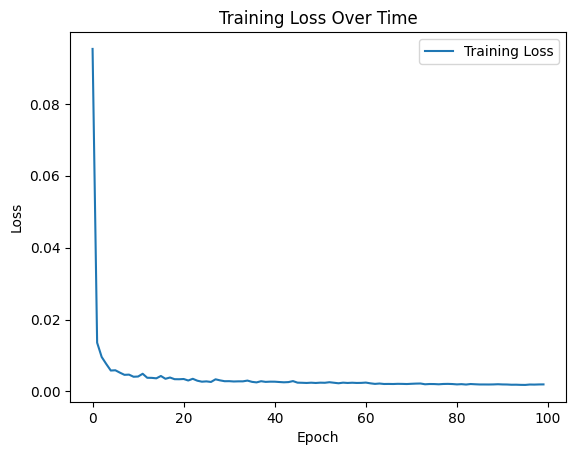

Task Train RMSE: 1.9363362789154053, Train R2: 0.9999899683889159, Train MAE: 1.3376785516738892
Task Test RMSE: 3.0505893230438232, Test R2: 0.9999726041513488, Test MAE: 1.7719695568084717
Task Train RMSE: 2.361743927001953, Train R2: 0.9999843991441572, Train MAE: 1.527154564857483
Task Test RMSE: 1.4114617109298706, Test R2: 0.9999948407249722, Test MAE: 1.014044165611267
Task Train RMSE: 2.053340196609497, Train R2: 0.9999880731280343, Train MAE: 1.346483588218689
Task Test RMSE: 2.7273921966552734, Test R2: 0.9999812109502814, Test MAE: 1.7367370128631592
Task Train RMSE: 2.340911865234375, Train R2: 0.9999852600959624, Train MAE: 1.464959740638733
Task Test RMSE: 1.544050693511963, Test R2: 0.9999934022369543, Test MAE: 1.2628265619277954
Task Train RMSE: 2.2978835105895996, Train R2: 0.9999863456633575, Train MAE: 1.4463920593261719
Task Test RMSE: 1.7839646339416504, Test R2: 0.9999885951129723, Test MAE: 1.3371063470840454
Task Train RMSE: 1.8902335166931152, Train R2: 0.9999

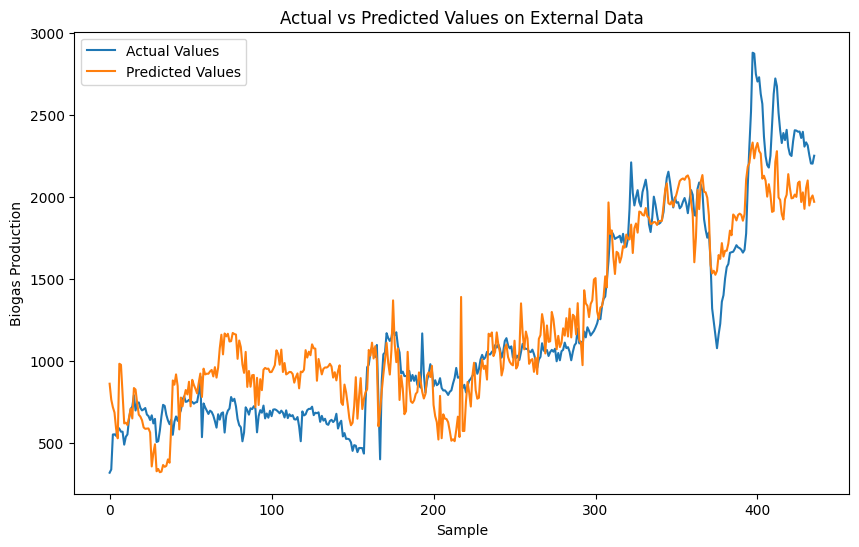

External Dataset - RMSE: 238.10546875, R2: 0.843667901293281, MAE: 194.20046997070312


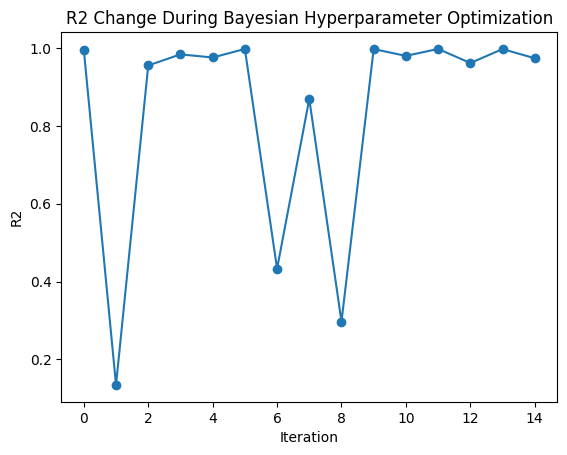

Original Dataset - RMSE: 2.1140626439927663, R2: 0.999987676184796, MAE: 1.4679174156188985
External Dataset - RMSE: 238.10546875, R2: 0.843667901293281, MAE: 194.20046997070312


In [3]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
import learn2learn as l2l
import numpy as np
import torch

np.random.seed(0)  # 设置NumPy的随机种子
torch.manual_seed(0)  # 设置PyTorch的随机种子

device = torch.device("cuda:0")  # Use GPU 0

# Hyperparameter search space
search_space = [
    Integer(500, 1500, name='hidden_size'), 
    Real(1e-11, 1e-6, "log-uniform", name='alpha'),  
    Real(1e-7, 1e-3, "log-uniform", name='beta'),
    Real(0.1, 0.8, name='dropout_rate'), 
    Real(1e-7, 1e-1, "log-uniform", name='weight_decay') 
]

# Data normalization and denormalization functions
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler

def normalize_feature(data, column_name):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column_name]])
    return scaled_data, scaler

def denormalize_data(normalized_data, scaler):
    return scaler.inverse_transform(normalized_data)

# Advanced neural network architecture
class AdvancedNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(AdvancedNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer4 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.dropout(x)
        x = self.layer4(x)
        return x

# Task creation function
def create_tasks(data, target_column, num_tasks=50, task_size=100):
    tasks = []
    for _ in range(num_tasks):
        task_data = data.sample(task_size)
        X, y = task_data.drop(target_column, axis=1), task_data[target_column]
        tasks.append((X, y))
    return tasks

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# MAML fast adaptation and meta-training
def meta_train_maml(model, tasks, alpha, beta, weight_decay, epochs=100, num_steps=1):
    early_stopping = EarlyStopping(patience=10, delta=0.01)
    optimizer = optim.Adam(model.parameters(), lr=beta, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    epoch_loss_list = []  # Initialize a list to store losses for each epoch

    for epoch in range(epochs):
        epoch_losses = []
        for task in tasks:
            learner = model.clone()  # Clone the model
            task_X, task_y = task
            task_X = torch.from_numpy(task_X.values).float().to(device)
            task_y = torch.from_numpy(task_y.values).float().to(device)

            # Fast adaptation
            for step in range(num_steps):
                pred_y = learner(task_X)
                loss = nn.functional.mse_loss(pred_y.squeeze(), task_y)
                learner.adapt(loss)

            # Meta-update
            optimizer.zero_grad()
            pred_y = learner(task_X)
            loss = nn.functional.mse_loss(pred_y.squeeze(), task_y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        scheduler.step()  # Update learning rate
        average_loss = np.mean(epoch_losses)
        epoch_loss_list.append(average_loss)  # Add each epoch's average loss to the list

        if early_stopping(average_loss, model):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return epoch_loss_list  # Return the list of epoch losses



@use_named_args(search_space)
def objective(hidden_size, alpha, beta, dropout_rate, weight_decay):
    model = AdvancedNeuralNetwork(input_size, hidden_size, dropout_rate)
    model = l2l.algorithms.MAML(model, lr=alpha).to(device)
    avg_r2 = 0

    task_r2_list = []  # 记录每个任务的 R2

    for task in tasks:
        task_X, task_y = task
        task_X_train, task_X_test, task_y_train, task_y_test = train_test_split(task_X, task_y, test_size=0.2, random_state=0)
        meta_train_maml(model, [(task_X_train, task_y_train)], alpha, beta, weight_decay, epochs=100)
        train_rmse, train_r2, train_mae, test_rmse, test_r2, test_mae = evaluate_model(model, task_X_train, task_y_train, task_X_test, task_y_test, target_scaler)
        task_r2_list.append(test_r2)  # 记录每个任务的测试 R2
        avg_r2 += test_r2

    avg_r2 /= len(tasks)
    return -avg_r2  # 这里返回负数因为 skopt 的目标函数是最小化，而我们想要最大化 R2

# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, target_scaler):
    model.eval()
    with torch.no_grad():
        # Convert data to tensors
        X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
        y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
        X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
        y_test_tensor = torch.from_numpy(y_test.values).float().to(device)

        # Get predictions
        train_predictions = model(X_train_tensor).squeeze().cpu().numpy()
        test_predictions = model(X_test_tensor).squeeze().cpu().numpy()

        # Reshape predictions for denormalization
        train_predictions_reshaped = train_predictions.reshape(-1, 1)
        test_predictions_reshaped = test_predictions.reshape(-1, 1)

        # Denormalize predictions using target_scaler
        train_predictions_denorm = denormalize_data(train_predictions_reshaped, target_scaler)
        test_predictions_denorm = denormalize_data(test_predictions_reshaped, target_scaler)

        # Denormalize actual values using target_scaler
        y_train_denorm = denormalize_data(y_train_tensor.cpu().numpy().reshape(-1, 1), target_scaler)
        y_test_denorm = denormalize_data(y_test_tensor.cpu().numpy().reshape(-1, 1), target_scaler)

        # Calculate metrics using denormalized data
        train_rmse = mean_squared_error(y_train_denorm, train_predictions_denorm, squared=False)
        train_r2 = r2_score(y_train_denorm, train_predictions_denorm)
        train_mae = mean_absolute_error(y_train_denorm, train_predictions_denorm)

        test_rmse = mean_squared_error(y_test_denorm, test_predictions_denorm, squared=False)
        test_r2 = r2_score(y_test_denorm, test_predictions_denorm)
        test_mae = mean_absolute_error(y_test_denorm, test_predictions_denorm)

    return train_rmse, train_r2, train_mae, test_rmse, test_r2, test_mae



data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\元学习\\BT（工厂训练）.csv")
data_normalized, scaler = normalize_data(data)
target_normalized, target_scaler = normalize_feature(data, 'Biogas Production')
external_data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\元学习\\imputed_data_BT（工厂验证）.csv")

# Create tasks using the normalized dataset
input_size = data.shape[1] - 1 
tasks = create_tasks(pd.DataFrame(data_normalized, columns=data.columns), target_column='Biogas Production')

# Execute hyperparameter optimization
result = gp_minimize(objective, search_space, n_calls=15,random_state=0)
hidden_size, alpha, beta, dropout_rate, weight_decay = result.x
print("Best parameters:", result.x)

# Train model with optimized hyperparameters
model = AdvancedNeuralNetwork(input_size, hidden_size, dropout_rate)
model = l2l.algorithms.MAML(model, lr=alpha).to(device)
train_losses = meta_train_maml(model, tasks, alpha, beta, weight_decay, epochs=100)

# Visualize training losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Final model evaluation
for task in tasks:
    X, y = task
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        train_rmse, train_r2, train_mae, test_rmse, test_r2, test_mae = evaluate_model(model, X_train, y_train, X_test, y_test, target_scaler)
        print(f"Task Train RMSE: {train_rmse}, Train R2: {train_r2}, Train MAE: {train_mae}")
        print(f"Task Test RMSE: {test_rmse}, Test R2: {test_r2}, Test MAE: {test_mae}")


# Load and process external data for evaluation

external_data_normalized, _ = normalize_data(external_data)
external_target_normalized, _ = normalize_feature(external_data, 'Biogas Production')
external_X = torch.from_numpy(pd.DataFrame(external_data_normalized, columns=external_data.columns).drop('Biogas Production', axis=1).values).float().to(device)
external_y_normalized = torch.from_numpy(external_target_normalized).float().to(device)

# Model prediction on external data
learner = model.clone()  # Clone the model for evaluation
learner.eval()
with torch.no_grad():
    external_predictions_normalized = learner(external_X).squeeze()
external_predictions = denormalize_data(external_predictions_normalized.cpu().numpy().reshape(-1, 1), target_scaler)
external_y = denormalize_data(external_y_normalized.cpu().numpy().reshape(-1, 1), target_scaler)

# Visualization of predictions on external data
plt.figure(figsize=(10, 6))
plt.plot(external_y, label='Actual Values')
plt.plot(external_predictions, label='Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Biogas Production')
plt.title('Actual vs Predicted Values on External Data')
plt.legend()
plt.show()

# Evaluate on external dataset using denormalized data
external_rmse = mean_squared_error(external_y, external_predictions, squared=False)
external_r2 = r2_score(external_y, external_predictions)
external_mae = mean_absolute_error(external_y, external_predictions)

print(f"External Dataset - RMSE: {external_rmse}, R2: {external_r2}, MAE: {external_mae}")

# 提取每次迭代的最佳 R2
best_r2_list = []
for res in result.func_vals:
    best_r2_list.append(-res)  # 注意要取负数

# 绘制 R2 的变化过程图
plt.plot(best_r2_list, marker='o')
plt.xlabel('Iteration')
plt.ylabel('R2')
plt.title('R2 Change During Bayesian Hyperparameter Optimization')
plt.show()

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

target_column = 'Biogas Production'

# 分离特征和目标变量
X = data.drop(target_column, axis=1)
y = data[target_column]
X_external = external_data.drop(target_column, axis=1)
y_external = external_data[target_column]

# 标准化数据
X_normalized, feature_scaler = normalize_data(X)
y_normalized, target_scaler = normalize_data(y.values.reshape(-1, 1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)

# 转换为 PyTorch 张量
X_train_tensor = torch.from_numpy(X_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

# 标准化外部数据集
X_external_normalized, _ = normalize_data(X_external)
y_external_normalized, _ = normalize_data(y_external.values.reshape(-1, 1))

# 转换外部数据为张量
X_external_tensor = torch.from_numpy(X_external_normalized).float().to(device)
y_external_tensor = torch.from_numpy(y_external_normalized).float().to(device)

# 模型预测函数
def model_predict(model, X_tensor):
    model.eval()
    with torch.no_grad():
        return model(X_tensor).cpu().numpy()

# 获取预测值
y_pred_train = model_predict(model, X_train_tensor).flatten()
y_pred_test = model_predict(model, X_test_tensor).flatten()
y_pred_external = model_predict(model, X_external_tensor).flatten()

# 反标准化预测值和实际值
y_pred_train_denorm = denormalize_data(y_pred_train.reshape(-1, 1), target_scaler).flatten()
y_pred_test_denorm = denormalize_data(y_pred_test.reshape(-1, 1), target_scaler).flatten()
y_pred_external_denorm = denormalize_data(y_pred_external.reshape(-1, 1), target_scaler).flatten()
y_train_denorm = denormalize_data(y_train, target_scaler).flatten()
y_test_denorm = denormalize_data(y_test, target_scaler).flatten()
y_external_denorm = denormalize_data(y_external_tensor.cpu().numpy(), target_scaler).flatten()


# 合并原始数据集和外部数据集的预测值和实际值
original_data_actual = np.concatenate([y_train_denorm, y_test_denorm])
original_data_predicted = np.concatenate([y_pred_train_denorm, y_pred_test_denorm])
external_data_actual = y_external_denorm
external_data_predicted = y_pred_external_denorm

# 创建 DataFrame
combined_df = pd.DataFrame({
    'Actual': np.concatenate([original_data_actual, external_data_actual]),
    'Predicted': np.concatenate([original_data_predicted, external_data_predicted]),
    'Dataset': ['Original'] * len(original_data_actual) + ['External'] * len(external_data_actual)
})

# 计算原始数据集的指标
train_r2 = r2_score(original_data_actual, original_data_predicted)
train_rmse = mean_squared_error(original_data_actual, original_data_predicted, squared=False)
train_mae = mean_absolute_error(original_data_actual, original_data_predicted)

# 计算外部数据集的指标
external_r2 = r2_score(external_data_actual, external_data_predicted)
external_rmse = mean_squared_error(external_data_actual, external_data_predicted, squared=False)
external_mae = mean_absolute_error(external_data_actual, external_data_predicted)


print(f"Original Dataset - RMSE: {train_rmse}, R2: {train_r2}, MAE: {train_mae}")
print(f"External Dataset - RMSE: {external_rmse}, R2: {external_r2}, MAE: {external_mae}")

GAN500

Best parameters: [1500, 1e-06, 0.001, 0.1, 1e-07]


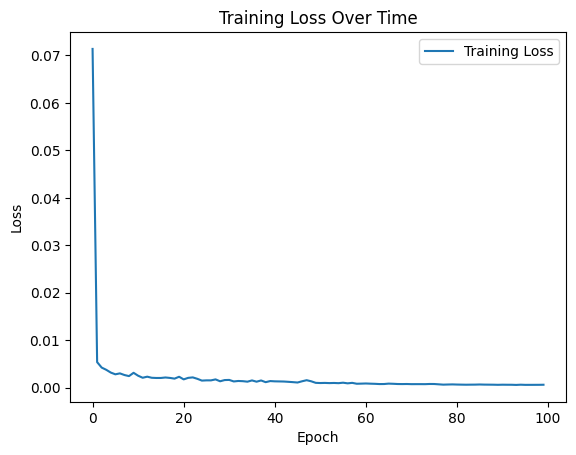

Task Train RMSE: 2.5948729515075684, Train R2: 0.999953963821822, Train MAE: 1.6639702320098877
Task Test RMSE: 3.532071828842163, Test R2: 0.9999453471526887, Test MAE: 2.176342725753784
Task Train RMSE: 2.8686368465423584, Train R2: 0.9999497866666337, Train MAE: 1.778997778892517
Task Test RMSE: 2.5480666160583496, Test R2: 0.9999604545867814, Test MAE: 1.716223120689392
Task Train RMSE: 2.7241475582122803, Train R2: 0.9999622991662237, Train MAE: 1.6382369995117188
Task Test RMSE: 3.1184964179992676, Test R2: 0.9996796332974347, Test MAE: 2.2792632579803467
Task Train RMSE: 2.8860549926757812, Train R2: 0.9999493379016479, Train MAE: 1.8412612676620483
Task Test RMSE: 2.4681458473205566, Test R2: 0.999963005931433, Test MAE: 1.4671783447265625
Task Train RMSE: 2.9489376544952393, Train R2: 0.9999421006989325, Train MAE: 1.9097449779510498
Task Test RMSE: 2.150357484817505, Test R2: 0.9999791192778469, Test MAE: 1.1932373046875
Task Train RMSE: 1.8570305109024048, Train R2: 0.999969

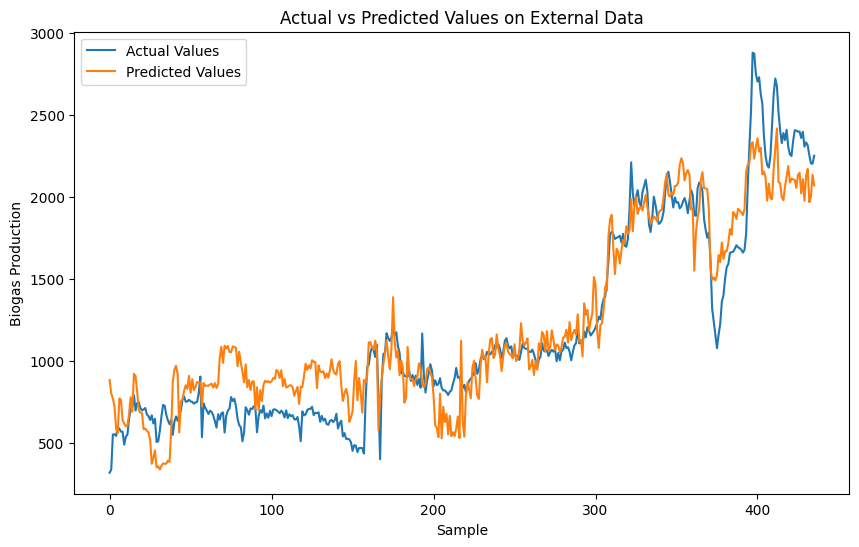

External Dataset - RMSE: 209.98194885253906, R2: 0.8784168536831047, MAE: 169.41488647460938


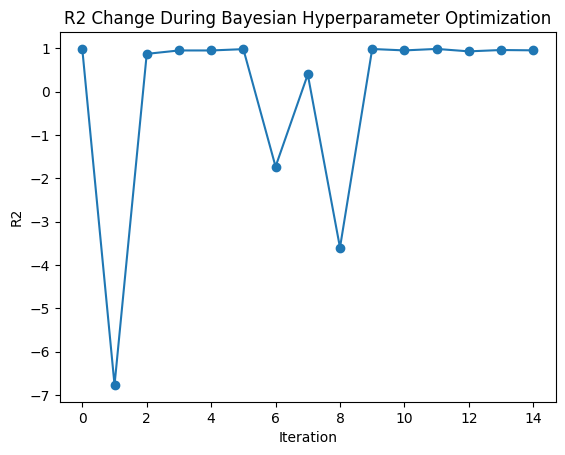

Original Dataset - RMSE: 4.755863934580019, R2: 0.9999376310669029, MAE: 3.013112758636479
External Dataset - RMSE: 209.98194885253906, R2: 0.8784168536831047, MAE: 169.41488647460938


In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import learn2learn as l2l
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 设置随机种子
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda:0")  # Use GPU 0

# Hyperparameter search space
search_space = [
    Integer(500, 1500, name='hidden_size'), 
    Real(1e-11, 1e-6, "log-uniform", name='alpha'),  
    Real(1e-7, 1e-3, "log-uniform", name='beta'),
    Real(0.1, 0.8, name='dropout_rate'), 
    Real(1e-7, 1e-1, "log-uniform", name='weight_decay') 
]

# Data normalization and denormalization functions
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler

def normalize_feature(data, column_name):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[column_name]])
    return scaled_data, scaler

def denormalize_data(normalized_data, scaler):
    return scaler.inverse_transform(normalized_data)

# 元学习模型定义
class AdvancedNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(AdvancedNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer4 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.dropout(x)
        x = self.layer4(x)
        return x

# 其他辅助函数和类（如EarlyStopping, create_tasks等）根据需要添加
# Task creation function
def create_tasks(data, target_column, num_tasks=50, task_size=100):
    tasks = []
    for _ in range(num_tasks):
        task_data = data.sample(task_size)
        X, y = task_data.drop(target_column, axis=1), task_data[target_column]
        tasks.append((X, y))
    return tasks

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# GAN的生成器定义
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x

# GAN的判别器定义
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        return x

# MAML fast adaptation and meta-training
def meta_train_maml(model, tasks, alpha, beta, weight_decay, epochs=100, num_steps=1):
    early_stopping = EarlyStopping(patience=10, delta=0.01)
    optimizer = optim.Adam(model.parameters(), lr=beta, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    epoch_loss_list = []  # Initialize a list to store losses for each epoch

    for epoch in range(epochs):
        epoch_losses = []
        for task in tasks:
            learner = model.clone()  # Clone the model
            task_X, task_y = task
            task_X = torch.from_numpy(task_X.values).float().to(device)
            task_y = torch.from_numpy(task_y.values).float().to(device)

            # Fast adaptation
            for step in range(num_steps):
                pred_y = learner(task_X)
                loss = nn.functional.mse_loss(pred_y.squeeze(), task_y)
                learner.adapt(loss)

            # Meta-update
            optimizer.zero_grad()
            pred_y = learner(task_X)
            loss = nn.functional.mse_loss(pred_y.squeeze(), task_y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        scheduler.step()  # Update learning rate
        average_loss = np.mean(epoch_losses)
        epoch_loss_list.append(average_loss)  # Add each epoch's average loss to the list

        if early_stopping(average_loss, model):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return epoch_loss_list  # Return the list of epoch losses



@use_named_args(search_space)
def objective(hidden_size, alpha, beta, dropout_rate, weight_decay):
    model = AdvancedNeuralNetwork(input_size, hidden_size, dropout_rate)
    model = l2l.algorithms.MAML(model, lr=alpha).to(device)
    avg_r2 = 0

    task_r2_list = []  # 记录每个任务的 R2

    for task in tasks:
        task_X, task_y = task
        task_X_train, task_X_test, task_y_train, task_y_test = train_test_split(task_X, task_y, test_size=0.2, random_state=0)
        meta_train_maml(model, [(task_X_train, task_y_train)], alpha, beta, weight_decay, epochs=100)
        train_rmse, train_r2, train_mae, test_rmse, test_r2, test_mae = evaluate_model(model, task_X_train, task_y_train, task_X_test, task_y_test, target_scaler)
        task_r2_list.append(test_r2)  # 记录每个任务的测试 R2
        avg_r2 += test_r2

    avg_r2 /= len(tasks)
    return -avg_r2  # 这里返回负数因为 skopt 的目标函数是最小化，而我们想要最大化 R2

# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, target_scaler):
    model.eval()
    with torch.no_grad():
        # Convert data to tensors
        X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
        y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
        X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
        y_test_tensor = torch.from_numpy(y_test.values).float().to(device)

        # Get predictions
        train_predictions = model(X_train_tensor).squeeze().cpu().numpy()
        test_predictions = model(X_test_tensor).squeeze().cpu().numpy()

        # Reshape predictions for denormalization
        train_predictions_reshaped = train_predictions.reshape(-1, 1)
        test_predictions_reshaped = test_predictions.reshape(-1, 1)

        # Denormalize predictions using target_scaler
        train_predictions_denorm = denormalize_data(train_predictions_reshaped, target_scaler)
        test_predictions_denorm = denormalize_data(test_predictions_reshaped, target_scaler)

        # Denormalize actual values using target_scaler
        y_train_denorm = denormalize_data(y_train_tensor.cpu().numpy().reshape(-1, 1), target_scaler)
        y_test_denorm = denormalize_data(y_test_tensor.cpu().numpy().reshape(-1, 1), target_scaler)

        # Calculate metrics using denormalized data
        train_rmse = mean_squared_error(y_train_denorm, train_predictions_denorm, squared=False)
        train_r2 = r2_score(y_train_denorm, train_predictions_denorm)
        train_mae = mean_absolute_error(y_train_denorm, train_predictions_denorm)

        test_rmse = mean_squared_error(y_test_denorm, test_predictions_denorm, squared=False)
        test_r2 = r2_score(y_test_denorm, test_predictions_denorm)
        test_mae = mean_absolute_error(y_test_denorm, test_predictions_denorm)

    return train_rmse, train_r2, train_mae, test_rmse, test_r2, test_mae



# 加载和规范化数据
data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\元学习\\BT（工厂训练）.csv")
data_normalized, scaler = normalize_data(data)
target_normalized, target_scaler = normalize_data(data[['Biogas Production']].values)
external_data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\元学习\\imputed_data_BT（工厂验证）.csv")


# 设置GAN训练参数
z_dim = 200  # 潜在空间的维度
gen_hidden_dim = 80
dis_hidden_dim = 80
lr = 0.0002
batch_size = 200
num_epochs = 200


# 初始化模型
generator = Generator(z_dim, gen_hidden_dim, data_normalized.shape[1]).to(device)
discriminator = Discriminator(data_normalized.shape[1], dis_hidden_dim).to(device)

# 优化器
optim_g = optim.Adam(generator.parameters(), lr=lr)
optim_d = optim.Adam(discriminator.parameters(), lr=lr)

tensor_data = torch.Tensor(data_normalized)
data_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

# GAN训练循环
for epoch in range(num_epochs):
    for batch in data_loader:
        current_batch_size = len(batch)  # Get the actual batch size
        real_data = batch.to(device)
        real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size based on batch
        fake_data = generator(torch.randn(current_batch_size, z_dim).to(device))  # Generate fake data based on current batch size
        fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust fake label size

        # 训练判别器
        optim_d.zero_grad()
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)
        d_loss_real = nn.BCEWithLogitsLoss()(real_output, real_labels)
        d_loss_fake = nn.BCEWithLogitsLoss()(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optim_d.step()

        # 训练生成器
        optim_g.zero_grad()
        fake_data = generator(torch.randn(current_batch_size, z_dim).to(device))  # Regenerate fake data
        fake_output = discriminator(fake_data)
        g_loss = nn.BCEWithLogitsLoss()(fake_output, real_labels)  # Use real_labels here
        g_loss.backward()
        optim_g.step()

# 假设您想生成一定数量的新样本
number_of_generated_samples = 500

# 生成新的数据样本
generated_samples = []
for _ in range(number_of_generated_samples):
    z = torch.randn(1, z_dim).to(device)
    generated_sample = generator(z).detach().cpu().numpy()
    generated_samples.append(generated_sample.reshape(-1))

generated_samples = np.array(generated_samples)

# 将生成的样本合并到现有数据中
extended_data = np.vstack([data_normalized, generated_samples])

# 创建增强的数据集任务
# 这里假设您已经定义了创建任务的函数
input_size = data.shape[1] - 1 
tasks = create_tasks(pd.DataFrame(extended_data, columns=data.columns), target_column='Biogas Production')
# Execute hyperparameter optimization
result = gp_minimize(objective, search_space, n_calls=15,random_state=0)
hidden_size, alpha, beta, dropout_rate, weight_decay = result.x
print("Best parameters:", result.x)

# Train model with optimized hyperparameters
model = AdvancedNeuralNetwork(input_size, hidden_size, dropout_rate)
model = l2l.algorithms.MAML(model, lr=alpha).to(device)
train_losses = meta_train_maml(model, tasks, alpha, beta, weight_decay, epochs=100)

# Visualize training losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Final model evaluation
for task in tasks:
    X, y = task
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        train_rmse, train_r2, train_mae, test_rmse, test_r2, test_mae = evaluate_model(model, X_train, y_train, X_test, y_test, target_scaler)
        print(f"Task Train RMSE: {train_rmse}, Train R2: {train_r2}, Train MAE: {train_mae}")
        print(f"Task Test RMSE: {test_rmse}, Test R2: {test_r2}, Test MAE: {test_mae}")
# Load and process external data for evaluation
external_data_normalized, _ = normalize_data(external_data)
external_target_normalized, _ = normalize_feature(external_data, 'Biogas Production')
external_X = torch.from_numpy(pd.DataFrame(external_data_normalized, columns=external_data.columns).drop('Biogas Production', axis=1).values).float().to(device)
external_y_normalized = torch.from_numpy(external_target_normalized).float().to(device)

# Model prediction on external data
learner = model.clone()  # Clone the model for evaluation
learner.eval()
with torch.no_grad():
    external_predictions_normalized = learner(external_X).squeeze()
external_predictions = denormalize_data(external_predictions_normalized.cpu().numpy().reshape(-1, 1), target_scaler)
external_y = denormalize_data(external_y_normalized.cpu().numpy().reshape(-1, 1), target_scaler)

# Visualization of predictions on external data
plt.figure(figsize=(10, 6))
plt.plot(external_y, label='Actual Values')
plt.plot(external_predictions, label='Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Biogas Production')
plt.title('Actual vs Predicted Values on External Data')
plt.legend()
plt.show()

# Evaluate on external dataset using denormalized data
external_rmse = mean_squared_error(external_y, external_predictions, squared=False)
external_r2 = r2_score(external_y, external_predictions)
external_mae = mean_absolute_error(external_y, external_predictions)

print(f"External Dataset - RMSE: {external_rmse}, R2: {external_r2}, MAE: {external_mae}")


# 提取每次迭代的最佳 R2
best_r2_list = []
for res in result.func_vals:
    best_r2_list.append(-res)  # 注意要取负数

# 绘制 R2 的变化过程图
plt.plot(best_r2_list, marker='o')
plt.xlabel('Iteration')
plt.ylabel('R2')
plt.title('R2 Change During Bayesian Hyperparameter Optimization')
plt.show()

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

target_column = 'Biogas Production'

# 分离特征和目标变量
X = data.drop(target_column, axis=1)
y = data[target_column]
X_external = external_data.drop(target_column, axis=1)
y_external = external_data[target_column]

# 标准化数据
X_normalized, feature_scaler = normalize_data(X)
y_normalized, target_scaler = normalize_data(y.values.reshape(-1, 1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)

# 转换为 PyTorch 张量
X_train_tensor = torch.from_numpy(X_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

# 标准化外部数据集
X_external_normalized, _ = normalize_data(X_external)
y_external_normalized, _ = normalize_data(y_external.values.reshape(-1, 1))

# 转换外部数据为张量
X_external_tensor = torch.from_numpy(X_external_normalized).float().to(device)
y_external_tensor = torch.from_numpy(y_external_normalized).float().to(device)

# 模型预测函数
def model_predict(model, X_tensor):
    model.eval()
    with torch.no_grad():
        return model(X_tensor).cpu().numpy()

# 获取预测值
y_pred_train = model_predict(model, X_train_tensor).flatten()
y_pred_test = model_predict(model, X_test_tensor).flatten()
y_pred_external = model_predict(model, X_external_tensor).flatten()

# 反标准化预测值和实际值
y_pred_train_denorm = denormalize_data(y_pred_train.reshape(-1, 1), target_scaler).flatten()
y_pred_test_denorm = denormalize_data(y_pred_test.reshape(-1, 1), target_scaler).flatten()
y_pred_external_denorm = denormalize_data(y_pred_external.reshape(-1, 1), target_scaler).flatten()
y_train_denorm = denormalize_data(y_train, target_scaler).flatten()
y_test_denorm = denormalize_data(y_test, target_scaler).flatten()
y_external_denorm = denormalize_data(y_external_tensor.cpu().numpy(), target_scaler).flatten()


# 合并原始数据集和外部数据集的预测值和实际值
original_data_actual = np.concatenate([y_train_denorm, y_test_denorm])
original_data_predicted = np.concatenate([y_pred_train_denorm, y_pred_test_denorm])
external_data_actual = y_external_denorm
external_data_predicted = y_pred_external_denorm

# 创建 DataFrame
combined_df = pd.DataFrame({
    'Actual': np.concatenate([original_data_actual, external_data_actual]),
    'Predicted': np.concatenate([original_data_predicted, external_data_predicted]),
    'Dataset': ['Original'] * len(original_data_actual) + ['External'] * len(external_data_actual)
})

# 计算原始数据集的指标
train_r2 = r2_score(original_data_actual, original_data_predicted)
train_rmse = mean_squared_error(original_data_actual, original_data_predicted, squared=False)
train_mae = mean_absolute_error(original_data_actual, original_data_predicted)

# 计算外部数据集的指标
external_r2 = r2_score(external_data_actual, external_data_predicted)
external_rmse = mean_squared_error(external_data_actual, external_data_predicted, squared=False)
external_mae = mean_absolute_error(external_data_actual, external_data_predicted)


print(f"Original Dataset - RMSE: {train_rmse}, R2: {train_r2}, MAE: {train_mae}")
print(f"External Dataset - RMSE: {external_rmse}, R2: {external_r2}, MAE: {external_mae}")

传统机器学习

e:\anaconda\envs\yuanxuexi2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
e:\anaconda\envs\yuanxuexi2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
e:\anaconda\envs\yuanxuexi2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
e:\anaconda\envs\yuanxuexi2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
e:\anaconda\envs\yuanxuexi2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


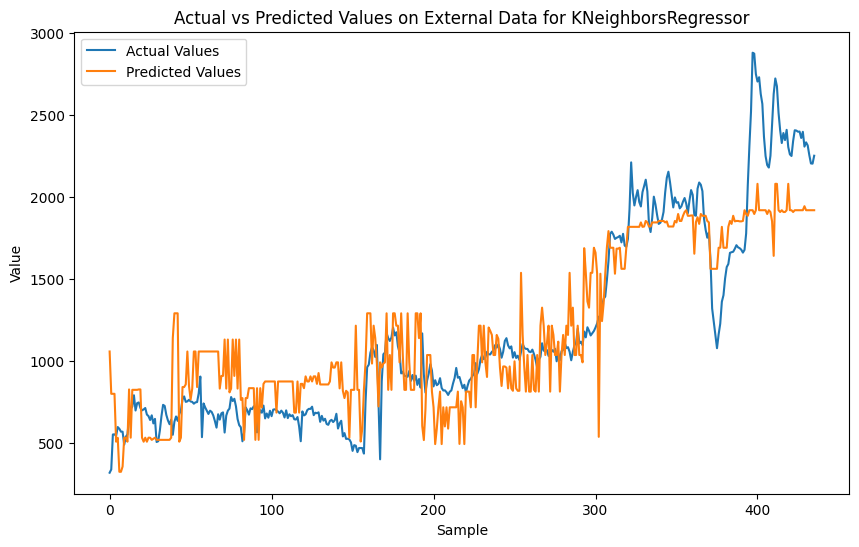

Model: KNeighborsRegressor
Train RMSE: 48.934498790475004 Train R2: 0.993596477472008 Train MAE: 38.250625
Test RMSE: 86.08220215657242 Test R2: 0.9756962363840104 Test MAE: 63.803437500000015
External RMSE: 278.10822766105315 External R2: 0.7867263764079846 External MAE: 220.30773357022093
--------------------------------------------------
Original Dataset - RMSE: 58.28976962662488, R2: 0.9906309803277665, MAE: 43.3611875
External Dataset - RMSE: 278.10822766105315, R2: 0.7867263764079846, MAE: 220.30773357022093


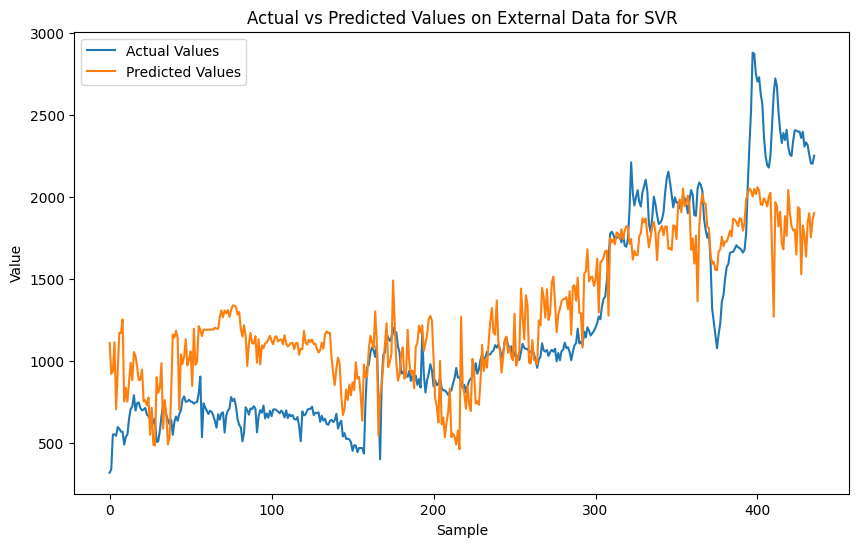

Model: SVR
Train RMSE: 26.708901290353563 Train R2: 0.998092341205753 Train MAE: 8.58525553340273
Test RMSE: 86.1457260473353 Test R2: 0.9756603534899521 Test MAE: 68.53520883592826
External RMSE: 356.45844779519484 External R2: 0.6496296909084132 External MAE: 293.63106179861154
--------------------------------------------------
Original Dataset - RMSE: 45.331110175626506, R2: 0.9943336658275633, MAE: 20.575246193907837
External Dataset - RMSE: 356.45844779519484, R2: 0.6496296909084132, MAE: 293.63106179861154


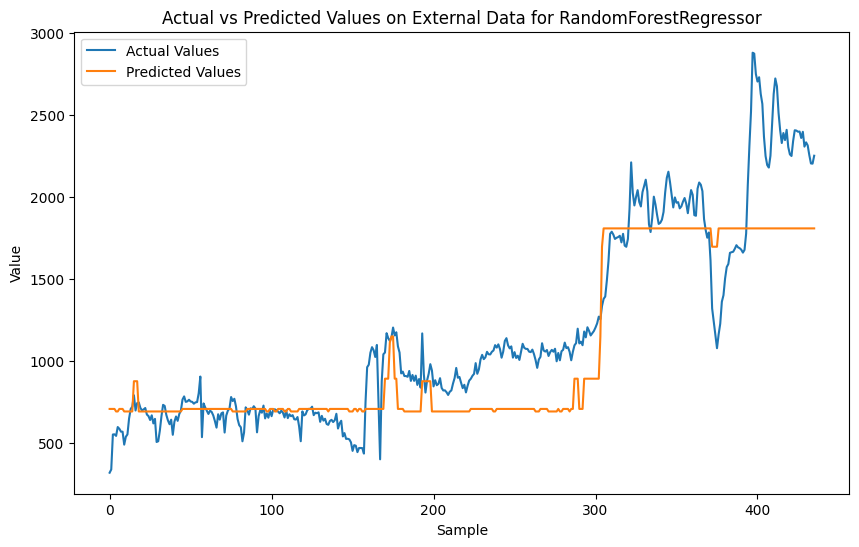

Model: RandomForestRegressor
Train RMSE: 222.71608914634254 Train R2: 0.8673547090722127 Train MAE: 187.17899891235808
Test RMSE: 230.20171138416075 Test R2: 0.8261943495813682 Test MAE: 188.71028978459069
External RMSE: 287.13596798001026 External R2: 0.7726553867896774 External MAE: 214.78467661387467
--------------------------------------------------
Original Dataset - RMSE: 224.2332060078359, R2: 0.8613533674926002, MAE: 187.48525708680464
External Dataset - RMSE: 287.13596798001026, R2: 0.7726553867896774, MAE: 214.78467661387467


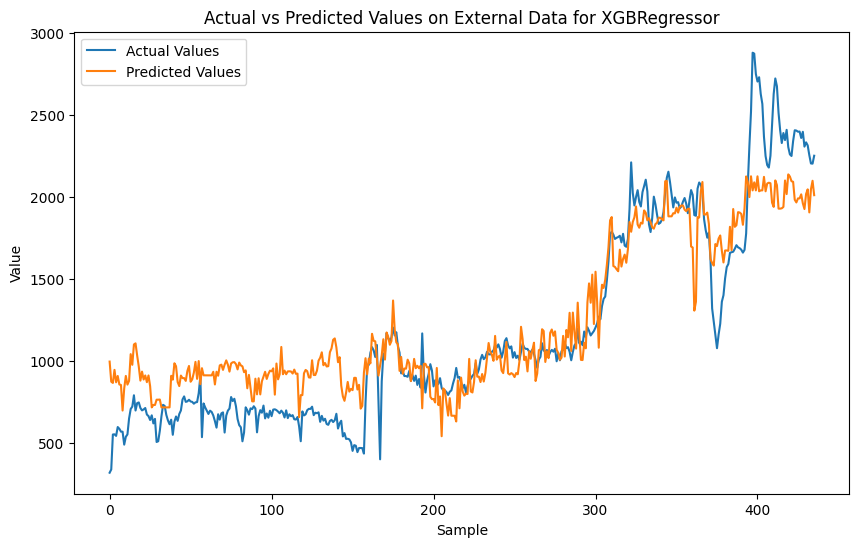

Model: XGBRegressor
Train RMSE: 0.3228608775784037 Train R2: 0.999999721247033 Train MAE: 0.24941413879394414
Test RMSE: 91.94903128345018 Test R2: 0.9722705591974057 Test MAE: 71.0328288269043
External RMSE: 248.63857780897055 External R2: 0.8295305739079447 External MAE: 196.2169004745628
--------------------------------------------------
Original Dataset - RMSE: 41.12187084885605, R2: 0.9953371096539942, MAE: 14.406097076416012
External Dataset - RMSE: 248.63857780897055, R2: 0.8295305739079447, MAE: 196.2169004745628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 8
[LightGBM] [Info] Start training from score 0.041634
[LightGBM] [Warning] No further splits with positive gain, best gain: -

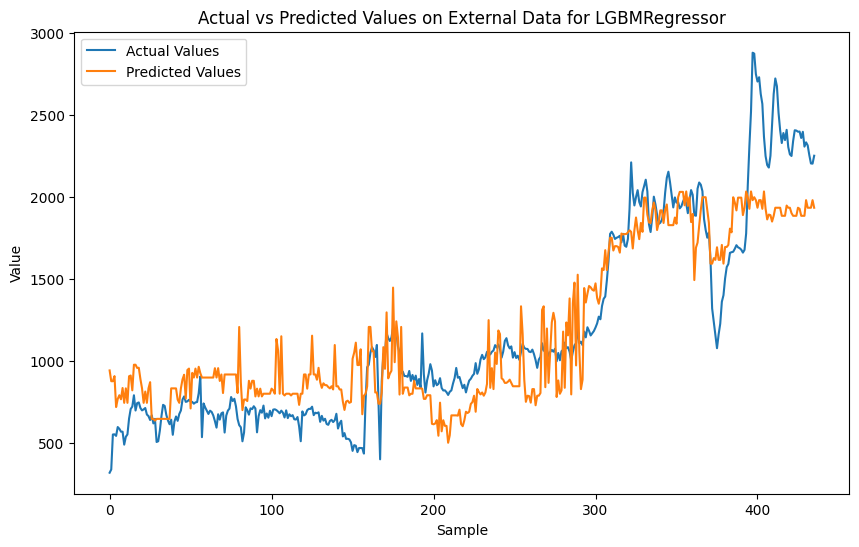

Model: LGBMRegressor
Train RMSE: 74.33462904974694 Train R2: 0.9852235193331067 Train MAE: 58.81348451227398
Test RMSE: 119.33679657090626 Test R2: 0.9532915402206726 Test MAE: 91.2494473897565
External RMSE: 263.64317081796474 External R2: 0.808335127092072 External MAE: 216.37334142273232
--------------------------------------------------
Original Dataset - RMSE: 85.25704583160243, R2: 0.9799566627745318, MAE: 65.30067708777048
External Dataset - RMSE: 263.64317081796474, R2: 0.808335127092072, MAE: 216.37334142273232


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Integer
import matplotlib.pyplot as plt
# Load datasets
data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\元学习\\BT（工厂训练）.csv")
external_data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\元学习\\imputed_data_BT（工厂验证）.csv")

# Normalization function
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler

# Normalize datasets
data_normalized, scaler = normalize_data(data)
external_data_normalized, _ = normalize_data(external_data)

# Split the dataset into features and target
X = data_normalized[:, :-1]
y = data_normalized[:, -1]
X_external = external_data_normalized[:, :-1]
y_external = external_data_normalized[:, -1]

# Fit a scaler for the features
feature_scaler = StandardScaler()
X_normalized = feature_scaler.fit_transform(data.drop('Biogas Production', axis=1))

# Fit a separate scaler for the target
target_scaler = StandardScaler()
y_normalized = target_scaler.fit_transform(data[['Biogas Production']])


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the hyperparameter space
param_grid = {'n_neighbors': Integer(1, 30)}

# Bayesian optimization
knn_search = BayesSearchCV(KNeighborsRegressor(), param_grid, n_iter=32, cv=5, n_jobs=-1, random_state=0)
knn_search.fit(X_train, y_train)

# Best model
knn_best = knn_search.best_estimator_

# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test, X_external, y_external, target_scaler):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_external = model.predict(X_external)

    # Denormalize target values and predictions
    y_train_denorm = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_external_denorm = target_scaler.inverse_transform(y_external.reshape(-1, 1)).flatten()
    y_pred_train_denorm = target_scaler.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
    y_pred_test_denorm = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    y_pred_external_denorm = target_scaler.inverse_transform(y_pred_external.reshape(-1, 1)).flatten()

    # Visualization of predictions on external data
    plt.figure(figsize=(10, 6))
    plt.plot(y_external_denorm, label='Actual Values')
    plt.plot(y_pred_external_denorm, label='Predicted Values')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Actual vs Predicted Values on External Data for {model.__class__.__name__}')
    plt.legend()
    plt.show()

    # Metrics for train and test sets
    train_rmse = mean_squared_error(y_train_denorm, y_pred_train_denorm, squared=False)
    test_rmse = mean_squared_error(y_test_denorm, y_pred_test_denorm, squared=False)
    train_r2 = r2_score(y_train_denorm, y_pred_train_denorm)
    test_r2 = r2_score(y_test_denorm, y_pred_test_denorm)
    train_mae = mean_absolute_error(y_train_denorm, y_pred_train_denorm)
    test_mae = mean_absolute_error(y_test_denorm, y_pred_test_denorm)

    # Metrics for external set
    external_rmse = mean_squared_error(y_external_denorm, y_pred_external_denorm, squared=False)
    external_r2 = r2_score(y_external_denorm, y_pred_external_denorm)
    external_mae = mean_absolute_error(y_external_denorm, y_pred_external_denorm)

    # Text for metrics
    metrics_text = f"RMSE: {external_rmse:.5f}\nR2: {external_r2:.5f}\nMAE: {external_mae:.5f}"

    # Create DataFrame for seaborn joint plot
    external_pred_df = pd.DataFrame({
        'Actual Values': y_external_denorm, 
        'Predicted Values': y_pred_external_denorm
    })

    # Print metrics
    print(f"Model: {model.__class__.__name__}")
    print("Train RMSE:", train_rmse, "Train R2:", train_r2, "Train MAE:", train_mae)
    print("Test RMSE:", test_rmse, "Test R2:", test_r2, "Test MAE:", test_mae)
    print("External RMSE:", external_rmse, "External R2:", external_r2, "External MAE:", external_mae)
    print("--------------------------------------------------")

    # 评估模型并获取训练集和测试集的预测值
    y_pred_train_denorm = target_scaler.inverse_transform(model.predict(X_train).reshape(-1, 1)).flatten()
    y_pred_test_denorm = target_scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).flatten()

    # 合并训练集和测试集的数据
    original_data_actual = np.concatenate([y_train_denorm, y_test_denorm])
    original_data_predicted = np.concatenate([y_pred_train_denorm, y_pred_test_denorm])

    # 创建包含原始数据集和外部数据集的 DataFrame
    combined_df = pd.DataFrame({
        'Actual': np.concatenate([original_data_actual, y_external_denorm]),
        'Predicted': np.concatenate([original_data_predicted, y_pred_external_denorm]),
        'Dataset': ['Original'] * len(original_data_actual) + ['External'] * len(y_external_denorm)
    })

    # 计算原始数据集的指标
    train_rmse = mean_squared_error(original_data_actual, original_data_predicted, squared=False)
    train_r2 = r2_score(original_data_actual, original_data_predicted)
    train_mae = mean_absolute_error(original_data_actual, original_data_predicted)

    # 计算外部数据集的指标
    external_rmse = mean_squared_error(y_external_denorm, y_pred_external_denorm, squared=False)
    external_r2 = r2_score(y_external_denorm, y_pred_external_denorm)
    external_mae = mean_absolute_error(y_external_denorm, y_pred_external_denorm)

    print(f"Original Dataset - RMSE: {train_rmse}, R2: {train_r2}, MAE: {train_mae}")
    print(f"External Dataset - RMSE: {external_rmse}, R2: {external_r2}, MAE: {external_mae}")

# Evaluate KNN model
evaluate_model(knn_best, X_train, y_train, X_test, y_test, X_external, y_external, target_scaler)

from sklearn.svm import SVR
from skopt.space import Real

# Define the hyperparameter space for SVM
param_grid_svm = {
    'C': Real(1e-15, 1e+1, prior='log-uniform'),
    'gamma': Real(1e-15, 1e+1, prior='log-uniform'),
    'epsilon': Real(1e-15, 1e+1, prior='log-uniform')
}

# Bayesian optimization
svm_search = BayesSearchCV(SVR(), param_grid_svm, n_iter=32, cv=5, n_jobs=-1, random_state=0)
svm_search.fit(X_train, y_train)

# Best model
svm_best = svm_search.best_estimator_

# Evaluate SVM model
evaluate_model(svm_best, X_train, y_train, X_test, y_test, X_external, y_external, target_scaler)

from sklearn.ensemble import RandomForestRegressor
from skopt.space import Integer, Real

# Define the hyperparameter space for Random Forest
param_grid_rf = {
    'n_estimators': Integer(10, 30),
    'max_depth': Integer(10, 30),
    'min_samples_split': Real(0.2, 0.8),
    'min_samples_leaf': Real(0.2, 0.8)
}

# Bayesian optimization
rf_search = BayesSearchCV(RandomForestRegressor(random_state=0), param_grid_rf, n_iter=32, cv=5, n_jobs=-1, random_state=0)
rf_search.fit(X_train, y_train)

# Best model
rf_best = rf_search.best_estimator_

# Evaluate Random Forest model
evaluate_model(rf_best, X_train, y_train, X_test, y_test, X_external, y_external, target_scaler)


import xgboost as xgb

# Define the hyperparameter space for XGBoost
param_grid_xgb = {
    'n_estimators': Integer(10, 50),
    'max_depth': Integer(10, 50),
    'learning_rate': Real(0.2, 0.8, 'log-uniform'),
    'subsample': Real(0.2, 0.8),
    'colsample_bytree': Real(0.2, 0.8)
}

# Bayesian optimization
xgb_search = BayesSearchCV(xgb.XGBRegressor(), param_grid_xgb, n_iter=32, cv=5, n_jobs=-1, random_state=0)
xgb_search.fit(X_train, y_train)

# Best model
xgb_best = xgb_search.best_estimator_

# Evaluate XGBoost model
evaluate_model(xgb_best, X_train, y_train, X_test, y_test, X_external, y_external, target_scaler)


import lightgbm as lgb

# Define the hyperparameter space for LightGBM
param_grid_lgb = {
    'n_estimators': Integer(1, 20),
    'max_depth': Integer(2, 20),
    'learning_rate': Real(0.3, 0.5, 'log-uniform'),
    'num_leaves': Integer(20, 50),
    'subsample': Real(0.3, 0.5),
    'colsample_bytree': Real(0.3, 0.5)
}

# Bayesian optimization
lgb_search = BayesSearchCV(lgb.LGBMRegressor(), param_grid_lgb, n_iter=32, cv=5, n_jobs=-1, random_state=0)
lgb_search.fit(X_train, y_train)

# Best model
lgb_best = lgb_search.best_estimator_

# Evaluate LightGBM model
evaluate_model(lgb_best, X_train, y_train, X_test, y_test, X_external, y_external, target_scaler)

In [2]:
# 创建包含模型名称和其最优超参数的字典
model_hyperparams = {
    'KNN': knn_search.best_params_,
    'SVM': svm_search.best_params_,
    'RandomForest': rf_search.best_params_,
    'XGBoost': xgb_search.best_params_,
    'LightGBM': lgb_search.best_params_
}

# 转换为DataFrame
hyperparams_df = pd.DataFrame.from_dict(model_hyperparams, orient='index')

# 重置索引，使模型名称成为一列
hyperparams_df.reset_index(inplace=True)
hyperparams_df.rename(columns={'index': 'Model'}, inplace=True)

# 指定文件路径和名称，这里替换为你的目标路径
file_path = "C:\\Users\\Lenovo\\Desktop\\元学习\\传统模型超参数\\hyperparams_GC_0_0.csv"

# 保存为CSV文件
hyperparams_df.to_csv(file_path, index=False)